<a href="https://colab.research.google.com/github/garodisk/Topic-Modelling-on-a-million-news-headlines/blob/master/Topic_Modelling_from_a_million_news_headlines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Topic Modelling from a million news headlines.**

Media, journals and newspaper around the world everyday have to cluster all th data they have into specific topics in order to show the articles or news in a structured manner under specific topics. Imagine having a digital library where the books are randomly placed irrespective of their topics. How difficult it will be to search for them or search for the books that belomgs to specific topics we are interested in. Fortunately, we have deep learning and analytical tools to rescue us from these situations.

In this project, I am going to extract topics from a million news headlines sourced from the reputable Australian news source ABC (Australian Broadcasting Corp.). The dataset is available in Kaggle.

https://www.kaggle.com/therohk/million-headlines

**Dataset Content**


publish_date: Date of publishing for the article in yyyyMMdd format

headline_text: Text of the headline in Ascii , English , lowercase

Start Date: 2003-02-19 ; End Date: 2019-12-31

We will explore this in two ways:

1) In the first case, we will create embeddings for each headlines using '**Google News wordtovec embeddings**' which takes care of the semantic and meaning and **cluster** the headlines into 8 clusters and see the most frequent words in the different clusters

2) In the second case, we will use **LDA** ( Latent Dirichlet Allocation) method to model the topics from these headlines. LDA assumes that each headline is taken from a nuber of topics and each topic consists fo several words.

Now, let us start with importing some of the libraries.



In [0]:
#importing libraries

import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
from google.colab import files
uploaded = files.upload()

Saving abcnews-date-text.csv to abcnews-date-text.csv


In [0]:
#our dataframe
headlines = pd.read_csv('abcnews-date-text.csv',parse_dates=[0], infer_datetime_format=True)

In [5]:
headlines.head()

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers


Now that we have imported our data, we will start will exploratory data analysis so that we have all the intuitions about what our data contains. Lets start will creating a column that contains the length of each headline to get an intuition on the average number of words used in a headline.

In [0]:
headlines['NumWords'] = headlines['headline_text'].apply(lambda x: len(x.split()))

In [7]:
headlines.describe()

,NumWords
count,1.103663e+06
mean,6.406747e+00
std,1.806453e+00
min,1.000000e+00
25%,5.000000e+00
50%,6.000000e+00
75%,8.000000e+00
max,1.500000e+01


Text(0.5, 1.0, 'Distributon of number of words in the headlines')

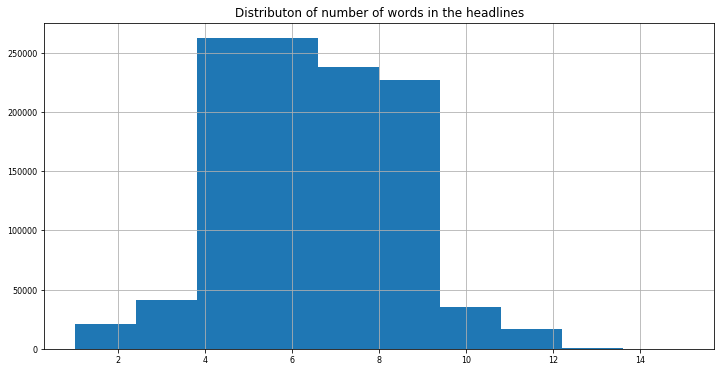

In [8]:
headlines[['NumWords']].hist(figsize=(12, 6), bins=10, xlabelsize=8, ylabelsize=8);
plt.title("Distributon of number of words in the headlines")

We can see that most of the headlines have around 4-6 words, Now lets also make a year, month and a day field to see the distribution of headlines across these attributes.

In [0]:
headlines['year'] = pd.DatetimeIndex(headlines['publish_date']).year
headlines['month'] = pd.DatetimeIndex(headlines['publish_date']).month
headlines['day'] = pd.DatetimeIndex(headlines['publish_date']).day

In [10]:
headlines.head()

,publish_date,headline_text,NumWords,year,month,day
0,2003-02-19,aba decides against community broadcasting lic...,6,2003,2,19
1,2003-02-19,act fire witnesses must be aware of defamation,8,2003,2,19
2,2003-02-19,a g calls for infrastructure protection summit,7,2003,2,19
3,2003-02-19,air nz staff in aust strike for pay rise,9,2003,2,19
4,2003-02-19,air nz strike to affect australian travellers,7,2003,2,19


Text(0.5, 1.0, 'Distributon of number of headlines across days')

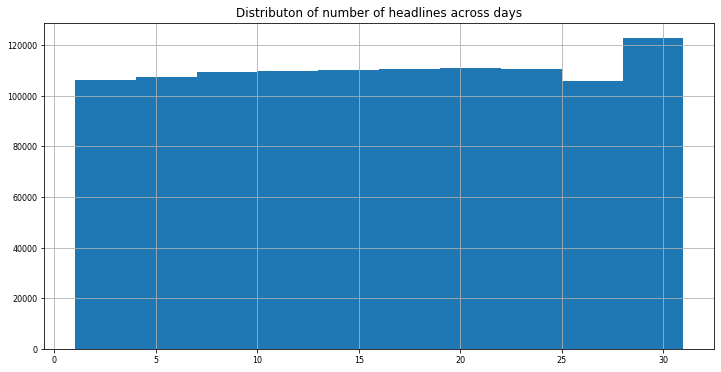

In [11]:
headlines['day'].hist(figsize=(12, 6), bins=10, xlabelsize=8, ylabelsize=8);
plt.title("Distributon of number of headlines across days")

Seems like the distribution is uniform across the days.

Text(0.5, 1.0, 'Distributon of number of headlines across months')

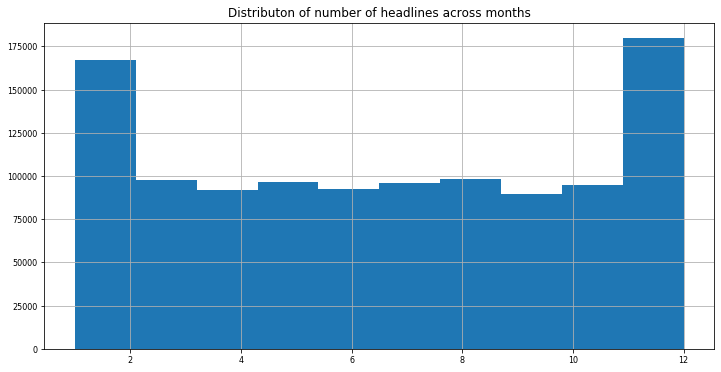

In [12]:
headlines['month'].hist(figsize=(12, 6), bins=10, xlabelsize=8, ylabelsize=8);
plt.title("Distributon of number of headlines across months")

The start and the end of the year have contributed to most of the headlines in the dataset.

Text(0.5, 1.0, 'Distributon of number of headlines across years')

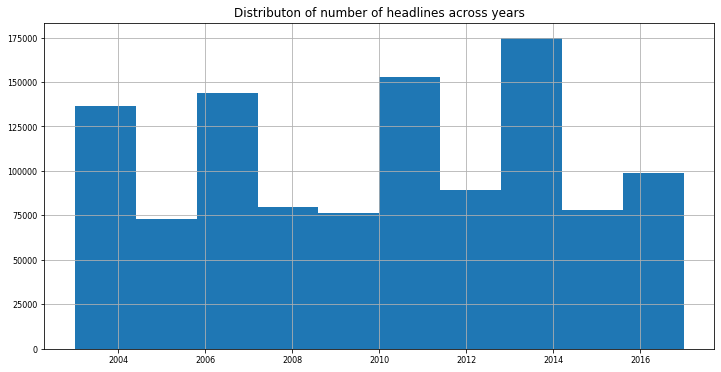

In [21]:
headlines['year'].hist(figsize=(12, 6), bins=10, xlabelsize=8, ylabelsize=8);
plt.title("Distributon of number of headlines across years")

Ssimilarly, we can see how the number of headlines is distributed across the years.

In [0]:
headlines.index = headlines['publish_date']

Now, lets visualize in a time-series pattern to see the everyday changes in the number of headlines. This will give us a better intuition and will be interesting to think about all the reasons that could have contributed to the spike during some years.

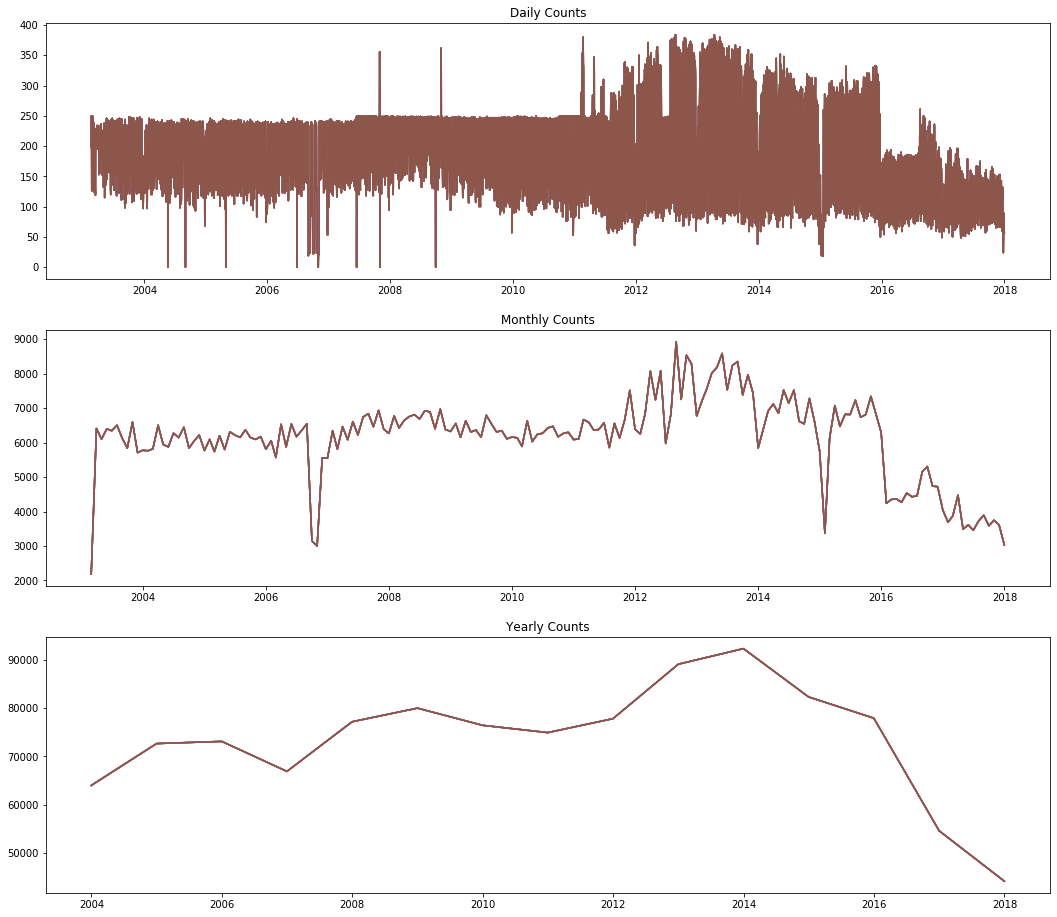

In [23]:
monthly_counts = headlines.resample('M').count()
yearly_counts = headlines.resample('A').count()
daily_counts = headlines.resample('D').count()

fig, ax = plt.subplots(3, figsize=(18,16))
ax[0].plot(daily_counts);
ax[0].set_title('Daily Counts');
ax[1].plot(monthly_counts);
ax[1].set_title('Monthly Counts');
ax[2].plot(yearly_counts);
ax[2].set_title('Yearly Counts');
plt.show()

Now, let us build a wordcloud to see the most frequent words that are being used in the headlines over the years.

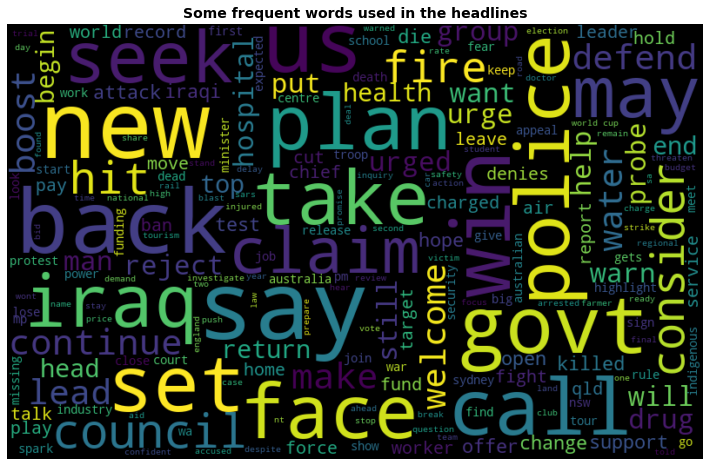

In [29]:
from wordcloud import WordCloud
all_words = ''.join([word for word in headlines['headline_text'][0:100000]])
all_words
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Some frequent words used in the headlines", weight='bold', fontsize=14)
plt.show()

The wordcloud seems so interesting. Inspite of the news channel belonging to Australia, we can see some frequent words like 'iraq' and some other words like 'police', 'plan', 'health', 'council', etc.

Now, let us move forward with performing some cleaning operations like turning each word to lowercase font, removing the punctuations and non ASCII characters which are irrrelevant for modelling topics out of these headlines.

In [13]:
import re
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
def normalize_texts(texts):
  normalized_texts = ''
  lower = texts.lower()
  no_punctuation = NON_ALPHANUM.sub(r' ', lower)
  no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
  return no_non_ascii
  
headlines['headline_text'] = headlines['headline_text'].apply(normalize_texts)
headlines.head()

,publish_date,headline_text,NumWords,year,month,day
0,2003-02-19,aba decides against community broadcasting lic...,6,2003,2,19
1,2003-02-19,act fire witnesses must be aware of defamation,8,2003,2,19
2,2003-02-19,a g calls for infrastructure protection summit,7,2003,2,19
3,2003-02-19,air nz staff in aust strike for pay rise,9,2003,2,19
4,2003-02-19,air nz strike to affect australian travellers,7,2003,2,19


In [0]:
headlines['headline_text'] = headlines['headline_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))


Lets draw one last plot for the top 15 words used with their frequencies.

In [0]:
def get_top_n_words(corpus, n=10):
  vec = CountVectorizer(stop_words='english').fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0) 
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq[:n]

In [16]:
get_top_n_words(headlines['headline_text'],15)

[('police', 35985),
 ('new', 29099),
 ('man', 28111),
 ('says', 20002),
 ('govt', 16935),
 ('court', 16383),
 ('council', 16363),
 ('interview', 15025),
 ('nsw', 12921),
 ('australia', 12684),
 ('plan', 12307),
 ('water', 11877),
 ('qld', 11791),
 ('crash', 11208),
 ('death', 11174)]

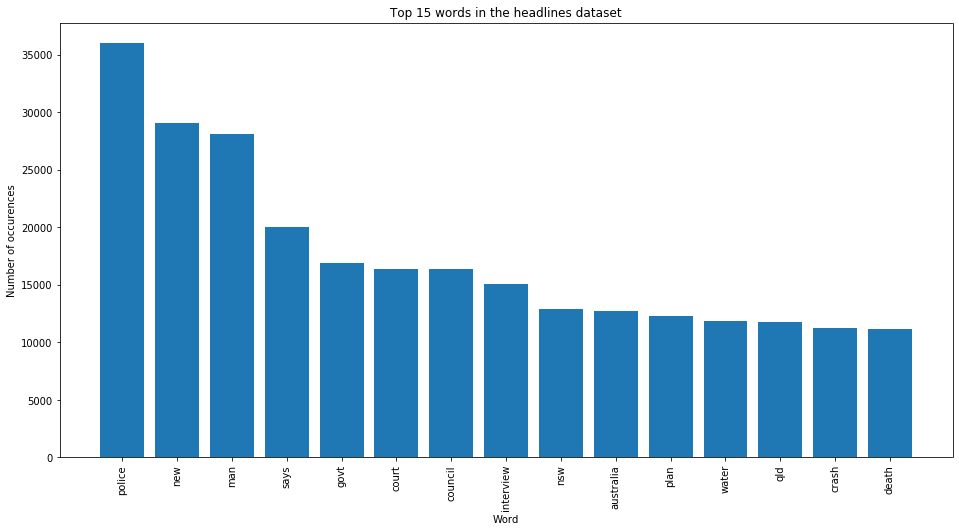

In [17]:
words = []
word_values = []
for i,j in get_top_n_words(headlines['headline_text'],15):
  words.append(i)
  word_values.append(j)
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top 15 words in the headlines dataset');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

## **Method 1** : Clustering using wordtovec embeddings

Now, lets start with our first mothod. We will import the word embeddings from the pre-trained deep NN on google news and then represent each headline with the mean of word embeddings for each word in that headline. Hold on if it seems cocmplicated.

In [18]:
X = headlines.loc[:,'headline_text'].as_matrix()
count_vect = CountVectorizer(lowercase=True )
count_vect = count_vect.fit(X)
X_sparse = count_vect.transform(X)
vocab = count_vect.vocabulary_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [0]:
vocab_inverse = {}
for word, int_embedding in vocab.items():
    vocab_inverse[int_embedding] = word

Vocab contains word to index representation and vocab inverse contains index to word representation. We have used count_vectorizer just to build our vocab and vocab_inverse right now.

In [20]:
X_sparse

<1103663x91134 sparse matrix of type '<class 'numpy.int64'>'
	with 6201758 stored elements in Compressed Sparse Row format>

In [21]:
vocab

{'aba': 215,
 'decides': 20552,
 'against': 1448,
 'community': 16647,
 'broadcasting': 10846,
 'licence': 46425,
 'act': 833,
 'fire': 28941,
 'witnesses': 89174,
 'must': 54147,
 'aware': 5378,
 'defamation': 20728,
 'calls': 12386,
 'for': 29877,
 'infrastructure': 39613,
 'protection': 63757,
 'summit': 78214,
 'air': 1764,
 'staff': 76442,
 'aust': 5077,
 'strike': 77598,
 'pay': 59827,
 'rise': 68558,
 'affect': 1316,
 'australian': 5131,
 'travellers': 82591,
 'ambitious': 2658,
 'olsson': 57321,
 'wins': 89014,
 'triple': 82923,
 'jump': 42091,
 'antic': 3366,
 'delighted': 21006,
 'with': 89131,
 'record': 66172,
 'breaking': 10460,
 'barca': 6360,
 'aussie': 5071,
 'qualifier': 64557,
 'stosur': 77368,
 'wastes': 87478,
 'four': 30202,
 'memphis': 50947,
 'match': 49737,
 'addresses': 967,
 'security': 71901,
 'council': 18262,
 'over': 58279,
 'iraq': 40530,
 'australia': 5129,
 'locked': 47135,
 'into': 40270,
 'war': 87227,
 'timetable': 81382,
 'opp': 57587,
 'contribute'

In [22]:
vocab_inverse

{215: 'aba',
 20552: 'decides',
 1448: 'against',
 16647: 'community',
 10846: 'broadcasting',
 46425: 'licence',
 833: 'act',
 28941: 'fire',
 89174: 'witnesses',
 54147: 'must',
 5378: 'aware',
 20728: 'defamation',
 12386: 'calls',
 29877: 'for',
 39613: 'infrastructure',
 63757: 'protection',
 78214: 'summit',
 1764: 'air',
 76442: 'staff',
 5077: 'aust',
 77598: 'strike',
 59827: 'pay',
 68558: 'rise',
 1316: 'affect',
 5131: 'australian',
 82591: 'travellers',
 2658: 'ambitious',
 57321: 'olsson',
 89014: 'wins',
 82923: 'triple',
 42091: 'jump',
 3366: 'antic',
 21006: 'delighted',
 89131: 'with',
 66172: 'record',
 10460: 'breaking',
 6360: 'barca',
 5071: 'aussie',
 64557: 'qualifier',
 77368: 'stosur',
 87478: 'wastes',
 30202: 'four',
 50947: 'memphis',
 49737: 'match',
 967: 'addresses',
 71901: 'security',
 18262: 'council',
 58279: 'over',
 40530: 'iraq',
 5129: 'australia',
 47135: 'locked',
 40270: 'into',
 87227: 'war',
 81382: 'timetable',
 57587: 'opp',
 17567: 'cont

In [23]:
total_words = X_sparse.sum()
total_words_unique = len(count_vect.vocabulary_)

print('total_words: {}'.format(total_words))
print('total_words_unique: {}'.format(total_words_unique))

total_words: 6213736
total_words_unique: 91134


The total number of unique words are 91134 in the million headlines.

In [24]:
total_words = X_sparse.sum()
total_words_unique = len(count_vect.vocabulary_)

print('total_words: {}'.format(total_words))
print('total_words_unique: {}'.format(total_words_unique))

total_words: 6213736
total_words_unique: 91134


In [25]:
pip install --upgrade gensim

     |████████████████████████████████| 24.2MB 130kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [0]:
#importing wordtovec embeddings 
from gensim.models import KeyedVectors
pretrained_embeddings_path = "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

word2vec = KeyedVectors.load_word2vec_format(pretrained_embeddings_path, binary=True)

Lets see how a word is represented in its embedding format.

In [27]:
word = 'iraq'
print('Word: {}'.format(word))
print('First 20 values of embedding:\n{}'.format(word2vec[word][:20]))

Word: iraq
First 20 values of embedding:
[-0.27539062  0.13574219 -0.15332031  0.11962891 -0.25585938  0.00793457
  0.04638672 -0.35546875 -0.11474609  0.32617188  0.05859375 -0.33203125
 -0.36914062  0.04321289  0.25585938  0.18261719 -0.15527344 -0.171875
 -0.11230469 -0.20507812]


Let me show you the beauty of the word embeddings first. It captures synonyms, antonyms and all the logical analogies which humans can understand. If someone aasks you "What is woman+king-man, the first thing which comes to our mind will be queen. Now lets see what wordtovec embeddings gives as as the most similar answers to this question.

In [28]:
print(word2vec.most_similar(positive=['woman', 'king'], negative=['man'], topn=3))

print(word2vec.most_similar(positive=['Tennis', 'Ronaldo'], negative=['Soccer'], topn=3))

[('queen', 0.7118192911148071), ('monarch', 0.6189674139022827), ('princess', 0.5902431011199951)]
[('Nadal', 0.6514425277709961), ('Safin', 0.6181677579879761), ('Federer', 0.6156208515167236)]


Well, it is quite intelligent to give queen.

In [29]:
X.shape

(1103663,)

Now, we will randomly sample 20% of the data because of the memory constraints and then build the clustering model using the word embeddings we just imported.

In [0]:
X_train = pd.DataFrame(X)
headlines_smaller = X_train.sample(frac = 0.2, random_state= 423)
headlines_smaller.columns = ['head_line']

In [31]:
headlines_smaller.head()

,head_line
35301,man pleads guilty possessing child porn
559511,victorian ski resorts enjoy record snowfalls
338538,rod stewarts son pleads not guilty assault
285024,crusaders hold off committed reds
171356,williams signs one year deal with swans


In [0]:
class WordVecVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = 300

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in texts.split() if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for texts in X
        ])

In [33]:
#representing each headline by the mean of word embeddings for the words used in the headlines.

wtv_vect = WordVecVectorizer(word2vec)
X_train_wtv = wtv_vect.transform(headlines_smaller.head_line)
print(X_train_wtv.shape)

(220733, 300)


Now we have 220733 headlines and each headline has 300 features . Lets use KMeans CLustering to cluster them into 8 clusters.

In [0]:
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=8, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(X_train_wtv)

In [0]:
df = pd.DataFrame({'headlines' :headlines_smaller.head_line, 'topic_cluster' :y_km })

In [36]:
df.head()

,headlines,topic_cluster
35301,man pleads guilty possessing child porn,1
559511,victorian ski resorts enjoy record snowfalls,4
338538,rod stewarts son pleads not guilty assault,1
285024,crusaders hold off committed reds,7
171356,williams signs one year deal with swans,7


Lets visualize the top 15 words in each cluster and think about the topic they might be representing.

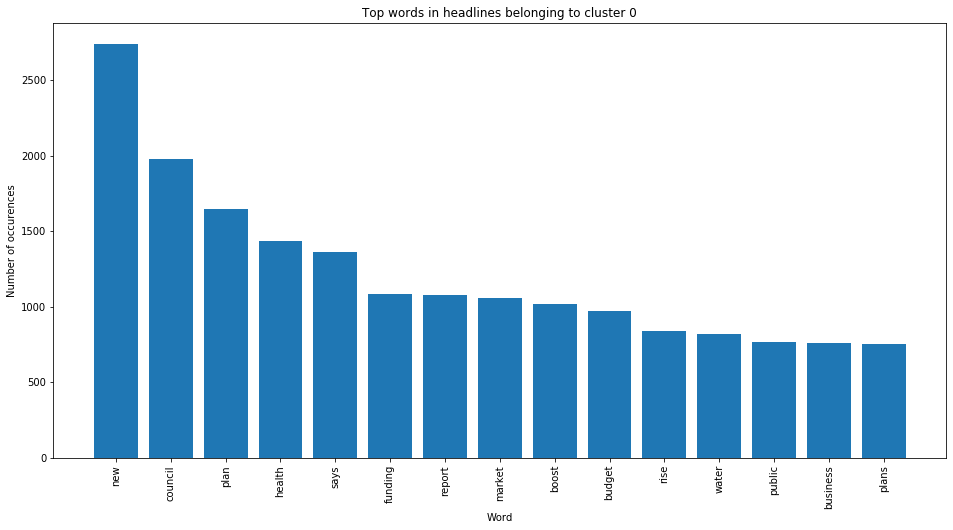

In [60]:
words = []
word_values = []
for i,j in get_top_n_words(df[df['topic_cluster'] == 0]['headlines'],15):
  words.append(i)
  word_values.append(j)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines belonging to cluster 0');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

Cluster 0 represents words like plan, health, budget, etc and seems like this belongs to the Economics or Business section of news.

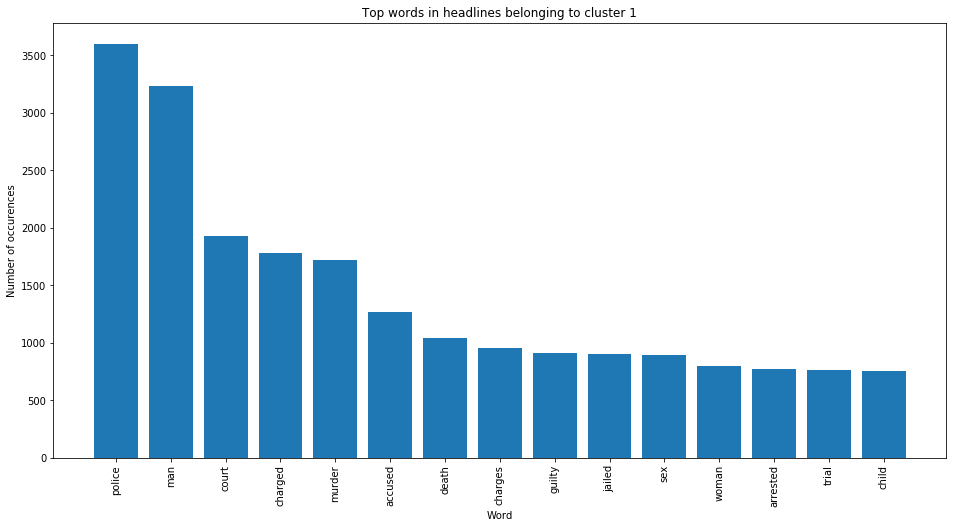

In [61]:
words = []
word_values = []
for i,j in get_top_n_words(df[df['topic_cluster'] == 1]['headlines'],15):
  words.append(i)
  word_values.append(j)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines belonging to cluster 1');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

Cluster 1 represents words like police, murder, death, etc and seems like this belongs to the Crime section of news.

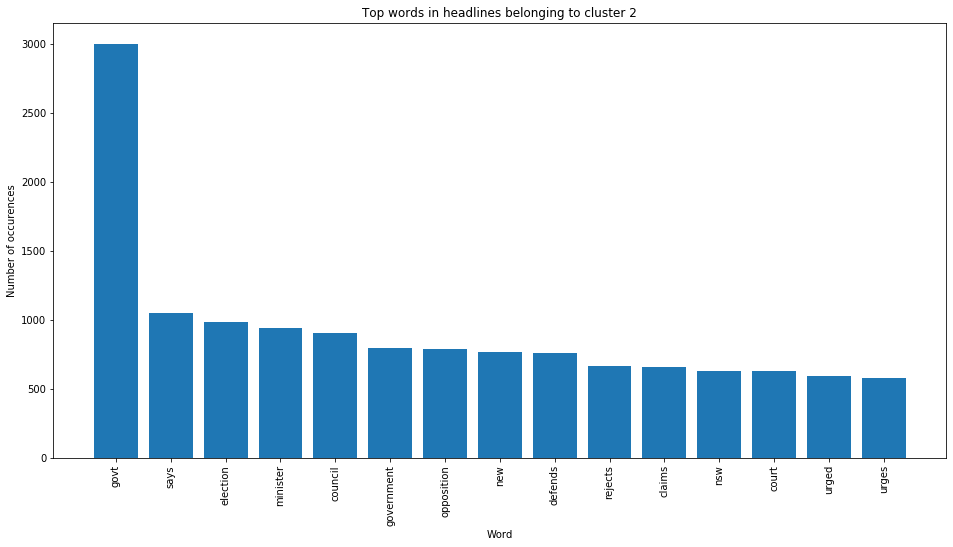

In [62]:
words = []
word_values = []
for i,j in get_top_n_words(df[df['topic_cluster'] == 2]['headlines'],15):
  words.append(i)
  word_values.append(j)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines belonging to cluster 2');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

Cluster 2 represents words like election, minister, court etc and seems like this belongs to the Politics section of news.

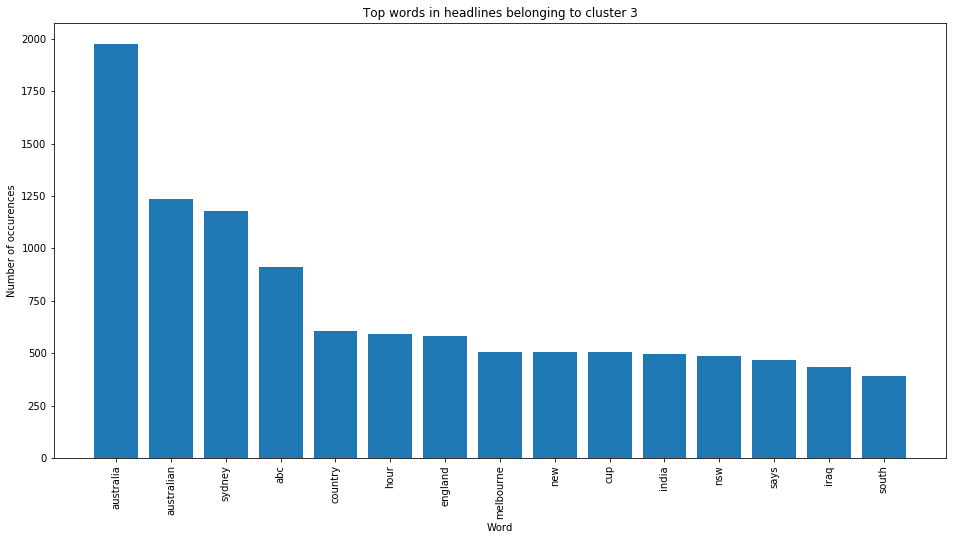

In [63]:
words = []
word_values = []
for i,j in get_top_n_words(df[df['topic_cluster'] == 3]['headlines'],15):
  words.append(i)
  word_values.append(j)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines belonging to cluster 3');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

Cluster 3 represents words like Australia, england, India, etc and seems like this belongs to the Global section of news.

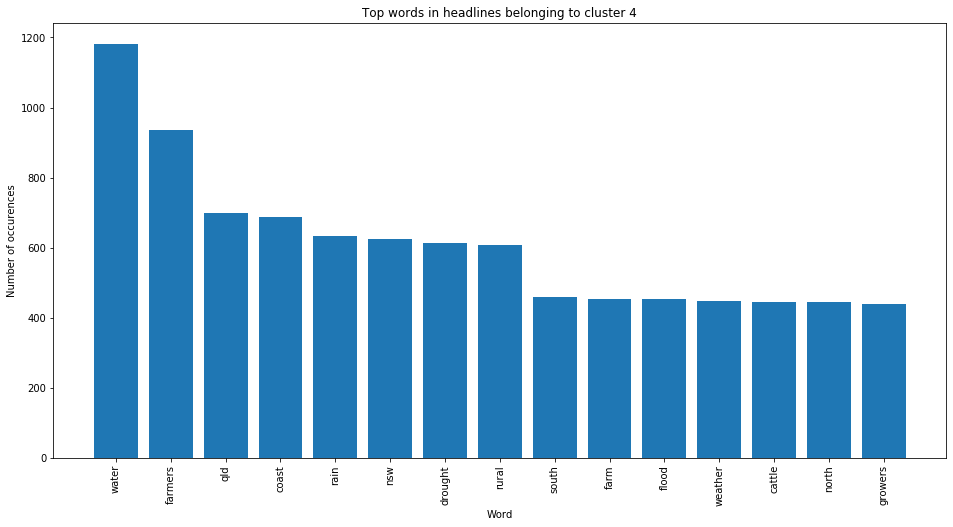

In [64]:
words = []
word_values = []
for i,j in get_top_n_words(df[df['topic_cluster'] == 4]['headlines'],15):
  words.append(i)
  word_values.append(j)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines belonging to cluster 4');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

Cluster 4 represents words like rural, water, flood etc and seems like this belongs to the Economics section but more towards micro issues.

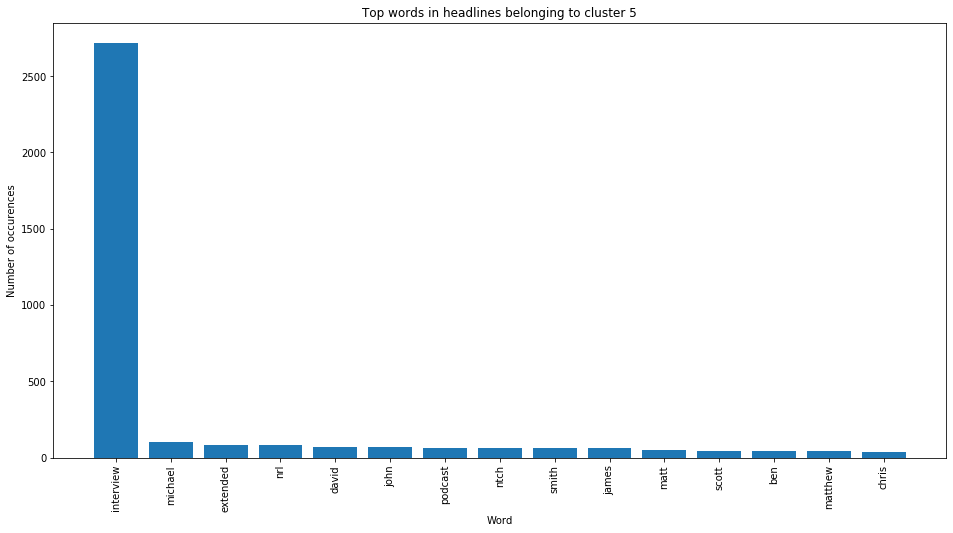

In [65]:
words = []
word_values = []
for i,j in get_top_n_words(df[df['topic_cluster'] == 5]['headlines'],15):
  words.append(i)
  word_values.append(j)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines belonging to cluster 5');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

Cluster 0 represents words like Michael, scoot, smith etc and seems like this belongs to the Interview or people section of news.

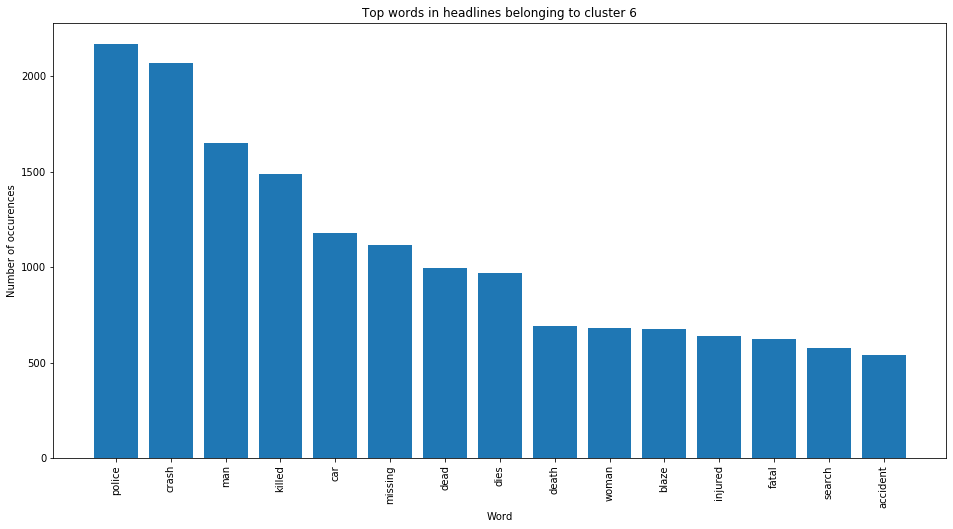

In [66]:
words = []
word_values = []
for i,j in get_top_n_words(df[df['topic_cluster'] == 6]['headlines'],15):
  words.append(i)
  word_values.append(j)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines belonging to cluster 6');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

Cluster 6 represents words like crash, killed, missing etc and seems like this belongs to the accidents or Currect happenings section of news.

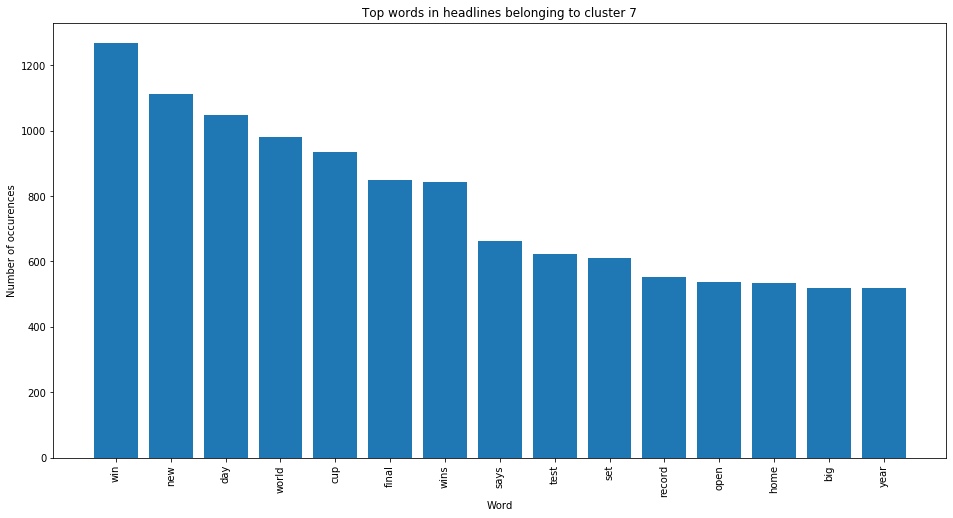

In [67]:
words = []
word_values = []
for i,j in get_top_n_words(df[df['topic_cluster'] == 7]['headlines'],15):
  words.append(i)
  word_values.append(j)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines belonging to cluster 7');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

Cluster 7 represents words like open, wins, final etc and seems like this belongs to the Sports section of news.

We can see that word2vec embeddings have led us to someq random news to news belonging to specific topics in a very intelligent way. Now, lets move on to Method 2

## **Method 2** : Clustering using LDA ( Latent Dirichlet Analysis)

LDA is a probabilitic method to extract the topics from documents. It assumes that each document is made up of several topics with different probability distribution and each topic is made up of several words with different distribution. So it works by initializing random topics to each word in each document and works in a reverse manner to discover the topics which would have generated these words in documents. To gain a high level intuition, read thiss blog - https://medium.com/@pratikbarhate/latent-dirichlet-allocation-for-beginners-a-high-level-intuition-23f8a5cbad71

Since, LDA has a lot of computations, we will sample 2% of the data and perform the analysis which might not lead to very intelligent topics but it will give us a high level understanding of what LDA does.

In [0]:
news = headlines.sample(frac = 0.02, random_state= 423)

In [52]:
news.head()

,publish_date,headline_text,NumWords,year,month,day
35301,2003-08-07,man pleads guilty possessing child porn,7,2003,8,7
559511,2010-08-26,victorian ski resorts enjoy record snowfalls,6,2010,8,26
338538,2007-10-19,rod stewarts son pleads not guilty assault,8,2007,10,19
285024,2007-02-10,crusaders hold off committed reds,5,2007,2,10
171356,2005-06-22,williams signs one year deal with swans,7,2005,6,22


In [53]:
news = news.drop(columns = 'publish_date')
news = news.reset_index()
news.head()

,index,headline_text,NumWords,year,month,day
0,35301,man pleads guilty possessing child porn,7,2003,8,7
1,559511,victorian ski resorts enjoy record snowfalls,6,2010,8,26
2,338538,rod stewarts son pleads not guilty assault,8,2007,10,19
3,285024,crusaders hold off committed reds,5,2007,2,10
4,171356,williams signs one year deal with swans,7,2005,6,22


We will build our features using TfIdf vectorizer which is basically similar to the bag-of-word model with the only difference being tfidf penalizes the words which are present in several documents. Now, Lets fit the LDA model and see what topics LDA extracted using top 15 words for each topic.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vectorizer = TfidfVectorizer(stop_words='english', max_features=50000)
news_matrix = tf_vectorizer.fit_transform(news['headline_text'])

In [55]:
news_matrix.shape

(22073, 17741)

In [0]:
#importing LDA

from gensim import corpora, models
from sklearn.decomposition import LatentDirichletAllocation

In [0]:
#Fitting LDA

lda = LatentDirichletAllocation(n_components=8, learning_method='online', 
                                          random_state=0, verbose=0, n_jobs = -1)
lda_model = lda.fit(news_matrix)

In [0]:
lda_matrix = lda_model.transform(news_matrix)

In [59]:
lda_matrix

array([[0.03685454, 0.03685145, 0.03686212, ..., 0.03685514, 0.74201929,
        0.03685145],
       [0.03654849, 0.03654849, 0.03654848, ..., 0.03657858, 0.03654849,
        0.03654848],
       [0.03669439, 0.0366944 , 0.03669439, ..., 0.03669439, 0.2368973 ,
        0.03669438],
       ...,
       [0.04179878, 0.55889824, 0.04179878, ..., 0.04179878, 0.04179878,
        0.04179878],
       [0.39602019, 0.05226958, 0.29036235, ..., 0.05226958, 0.05226958,
        0.05226957],
       [0.03686059, 0.33620426, 0.31799028, ..., 0.16148106, 0.03686773,
        0.03686059]])

In [0]:
def print_topics(model, count_vectorizer, n_top_words):
    words = tf_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
      
        print("\nTopic #%d:" % topic_idx )
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [61]:
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda_model, news_matrix, 15)

Topics found via LDA:

Topic #0:
accused council win wins boost national ban big tax protest warning appeal park services service

Topic #1:
australian road dies union iraq weather australia rural prices housing end bid faces hits anti

Topic #2:
police plan court missing man woman face crash deal car dead group inquiry perth cut

Topic #3:
interview says north labor rise public opposition house report fears election probe police cup calls

Topic #4:
sydney abc coast home plans south residents drug funds news continues jailed mining gold wants

Topic #5:
death govt nsw hospital killed urged high power qld market farmers china changes vic land

Topic #6:
charged country sex attack man budget child hour hit work gets government guilty concerns study

Topic #7:
day trial school health set minister funding support search fight new charges business adelaide water


You can try to understand what topics each of the above represent. once you start increasing the training sample, the topics will become more specific anad the model will extract more intelligently. Now lets use TSNE to plot all the documents and color them by the topics they represent according to LDA. Though we know that each document comes from several topics ( an assumption for LDA ), we will consider that for each document, the topic with highest probability is the topic that document is representing.

In [62]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=1000, verbose=1, random_state=0, angle=0.75)

tsne_features = model.fit_transform(lda_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 22073 samples in 0.031s...
[t-SNE] Computed neighbors for 22073 samples in 3.710s...
[t-SNE] Computed conditional probabilities for sample 1000 / 22073
[t-SNE] Computed conditional probabilities for sample 2000 / 22073
[t-SNE] Computed conditional probabilities for sample 3000 / 22073
[t-SNE] Computed conditional probabilities for sample 4000 / 22073
[t-SNE] Computed conditional probabilities for sample 5000 / 22073
[t-SNE] Computed conditional probabilities for sample 6000 / 22073
[t-SNE] Computed conditional probabilities for sample 7000 / 22073
[t-SNE] Computed conditional probabilities for sample 8000 / 22073
[t-SNE] Computed conditional probabilities for sample 9000 / 22073
[t-SNE] Computed conditional probabilities for sample 10000 / 22073
[t-SNE] Computed conditional probabilities for sample 11000 / 22073
[t-SNE] Computed conditional probabilities for sample 12000 / 22073
[t-SNE] Computed conditional probabilities for sa

In [63]:
tsne_features

array([[ 66.71296  ,  -7.8268685],
       [-29.878275 ,  59.431114 ],
       [-20.35403  ,  45.302887 ],
       ...,
       [ 20.388319 , -51.656956 ],
       [-55.630947 , -15.442449 ],
       [ 15.29733  , -25.835213 ]], dtype=float32)

In [66]:
tsne_features.shape

(22073, 2)

In [0]:
#get 25 gb ram

#a = []
#while(1):
#  a.append(1)

In [0]:
df = pd.DataFrame(tsne_features)
df['topic'] = lda_matrix.argmax(axis=1)
df.columns = ['TSNE1', 'TSNE2', 'topic']


In [69]:
df.head()

,TSNE1,TSNE2,topic
0,66.712959,-7.826869,6
1,-29.878275,59.431114,4
2,-20.354031,45.302887,3
3,-60.769482,16.174160,0
4,-53.544804,37.468460,2


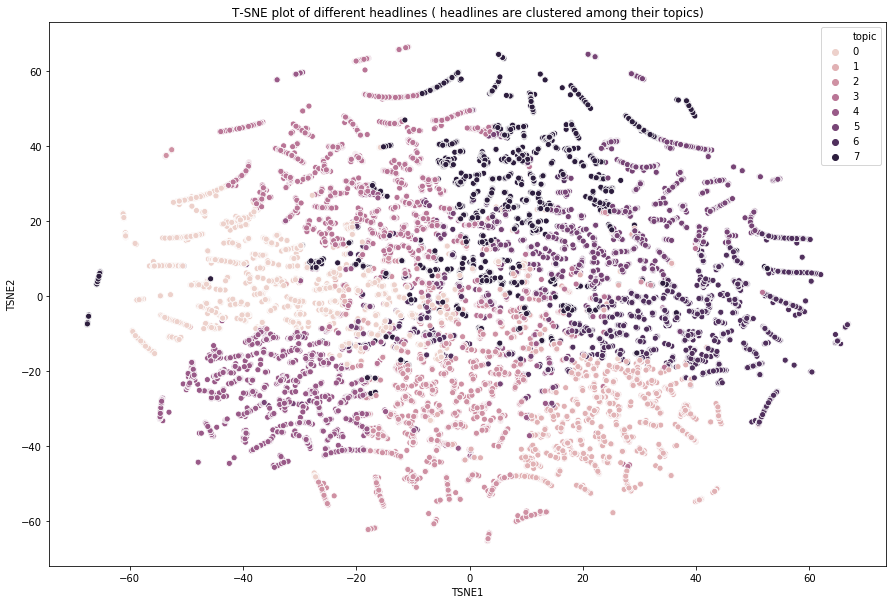

In [71]:
import seaborn as sns
plt.figure(figsize=(15, 10))
plt.title('T-SNE plot of different headlines ( headlines are clustered among their topics)')
ax = sns.scatterplot(x = 'TSNE1', y = 'TSNE2', hue = 'topic', data = df, legend = 'full')
plt.show()

We can see how different documents belong to their cluster from the TSNE plot.

I hope you atleast gain some insight on how topic modelling works. Now try scrapping data from twitter and try to get topics from those data. Thats how facebook, linkedin etc model the articles before recommending them to users.

Thank you.